<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#test" data-toc-modified-id="test-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>test</a></span></li></ul></div>

In [1]:

# 接口化后端
# task和attribute中间过程修改接口
# 关键词匹配列表&可视化推荐权重&其他可能（有泛化性、好理解）


In [2]:
import pandas as pd
import copy
import pprint
import xlsxwriter
from vega import VegaLite

#显示所有列
pd.set_option('display.max_columns', 20)
# pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', 20)
# pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

In [3]:
class My_DataFrame(pd.DataFrame):
    def __init__(self, data=None, index=None, columns=None, dtype=None, copy=False):
        pd.DataFrame.__init__(self, data, index, columns, dtype, copy)
 
    def my_mergewr_excel(self,path,key_cols=[],merge_cols=[]):
        # sheet_name='Sheet1', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, startrow=0, startcol=0, engine=None, merge_cells=True, encoding=None, inf_rep='inf', verbose=True):
        self_copy=My_DataFrame(self,copy=True)
        line_cn=self_copy.index.size
        cols=list(self_copy.columns.values)
#         if all([v in cols for i,v in enumerate(key_cols)])==False:     #校验key_cols中各元素 是否都包含与对象的列
#             print("key_cols is not completely include object's columns")
#             return False
        if all([v in cols for i,v in enumerate(merge_cols)])==False:  #校验merge_cols中各元素 是否都包含与对象的列
            print("merge_cols is not completely include object's columns")
            return False    
 
        wb2007 = xlsxwriter.Workbook(path)
        worksheet2007 = wb2007.add_worksheet()
        format_top = wb2007.add_format({'border':1,'bold':True,'text_wrap':True})
        format_other = wb2007.add_format({'border':1,'valign':'vcenter'})
        for i,value in enumerate(cols):  #写表头
            #print(value)
            worksheet2007.write(0,i,value,format_top)
        
        #merge_cols=['B','A','C']
        #key_cols=['A','B']
        if key_cols == []:   #如果key_cols 参数不传值，则无需合并
            self_copy['RN']=1
            self_copy['CN']=1
        else:
            self_copy['RN']=0
            self_copy['CN']=0
            start_pos=0
            end_pos=0
            pre_key =self_copy.loc[0,key_cols].to_list()          
        # generate RN and CN
            for i in range(line_cn):
                if self_copy.loc[i,key_cols].to_list() == pre_key:
                    end_pos = i
#                     print(i)
                else:
                    gap = end_pos-start_pos+1
                    for j in range(start_pos, end_pos+1):
                        self_copy.loc[j,'CN'] = gap
                        self_copy.loc[j,'RN'] = (j-start_pos)+1
#                     print("start_pos:"+str(start_pos)+",end_pos:"+str(end_pos)+',gap:'+str(end_pos-start_pos+1))
#                     print(pre_key)
                    start_pos = i
                    end_pos = start_pos
#                     print(i)
                    pre_key = self_copy.loc[i,key_cols].to_list()
            end_pos = line_cn-1
            gap = end_pos-start_pos+1
            for j in range(start_pos, end_pos+1):
                self_copy.loc[j,'CN'] = gap
                self_copy.loc[j,'RN'] = (j-start_pos)+1            
#             print("start_pos:"+str(start_pos)+",end_pos:"+str(line_cn-1)+',gap:'+str(line_cn-1-start_pos+1))
#             print(pre_key)
            
            
#             self_copy['RN']=self_copy.groupby(key_cols,as_index=False).rank(method='first').iloc[:,0] #以key_cols作为是否合并的依据
#             self_copy['CN']=self_copy.groupby(key_cols,as_index=False).rank(method='max').iloc[:,0]
        #print(self)
        for i in range(line_cn):
            if self_copy.loc[i,'CN']>1:
                #print('该行有需要合并的单元格')
                for j,col in enumerate(cols):
                    #print(self_copy.loc[i,col])
                    if col in (merge_cols):   #哪些列需要合并
                        if self_copy.loc[i,'RN']==1:  #合并写第一个单元格，下一个第一个将不再写
                            worksheet2007.merge_range(i+1,j,i+int(self_copy.loc[i,'CN']),j, self_copy.loc[i,col],format_other) ##合并单元格，根据LINE_SET[7]判断需要合并几个
                            #worksheet2007.write(i+1,j,df.loc[i,col])
                        else:
                            pass
                        #worksheet2007.write(i+1,j,df.loc[i,j])
                    else:
                        worksheet2007.write(i+1,j,self_copy.loc[i,col],format_other)
                    #print(',')
            else:
                #print('该行无需要合并的单元格')
                for j,col in enumerate(cols):
                    #print(df.loc[i,col])
                    worksheet2007.write(i+1,j,self_copy.loc[i,col],format_other)
        wb2007.close()
        self_copy.drop('CN', axis=1)
        self_copy.drop('RN', axis=1)
        
 

In [4]:
a=[1,2]+[1]

a

[1, 2, 1]

In [5]:
def show_transform_process(vl_spec,data,label_attr):
    filters = []
    has_agg = False
    has_count_agg =False
    fields = set()
    fields.add(label_attr)
    groupby_chnals={}
    groupby_list=[]
    agg_chnals={}
    column_name_of_agg_list=[]
    # prepare data structure for filters and aggs
    for fil in vl_spec['transform']:
        if type(fil['filter']) == type({}):
            tp = 'dict'
            field = fil['filter']['field']
            range_ = fil['filter']['oneOf']
            record = {'type':'filter_dict', 'field':field, 'range':range_}
        elif type(fil['filter']) == type(''):
            tp = 'str'
            left_idx_field = fil['filter'].find('["')+2
            right_idx_field = fil['filter'].find('"]')
            field = fil['filter'][left_idx_field:right_idx_field]
            left_idx_symbol = fil['filter'].find(']) ')+3
            right_idx_symbol = fil['filter'].find(']) ')+4  
            symbol = fil['filter'][left_idx_symbol:right_idx_symbol]
            left_idx_value = fil['filter'].find(']) ')+5
            value = float(fil['filter'][left_idx_value:])
            record = {'type':'filter_str', 'field':field, 'symbol':symbol,"value":value}
        fields.add(field)
        filters.append(record)
    for chan in vl_spec['encoding']:
        if 'field' in vl_spec['encoding'][chan]:
            fields.add(vl_spec['encoding'][chan]['field'])
        if 'aggregate' in vl_spec['encoding'][chan]:
            has_agg = True
            if 'field' in vl_spec['encoding'][chan]:
                agg_chnals[chan] = {'field':vl_spec['encoding'][chan]['field'],'op':vl_spec['encoding'][chan]['aggregate'],'column_name_of_agg':vl_spec['encoding'][chan]['aggregate']+' OF '+vl_spec['encoding'][chan]['field']}
                column_name_of_agg_list.append(agg_chnals[chan]['column_name_of_agg'])
            ### this aggregation is for count
            else:
                has_count_agg = True
                fields.add('count of record')
                agg_chnals[chan] = {'field':'count of record','op':'sum','column_name_of_agg':'sum'+' OF '+'count of record'}
                column_name_of_agg_list.append(agg_chnals[chan]['column_name_of_agg'])                
        else:
            groupby_chnals[chan] = {'field':vl_spec['encoding'][chan]['field'] }
            groupby_list.append(vl_spec['encoding'][chan]['field'])
        
#     print(filters)
#     print(agg_chnals)
#     print(groupby_chnals)
#     print(fields)

    df = pd.read_csv(data) 
    if has_count_agg == True:
        df['count of record'] = 1
        
    fields = list(fields)
    
    # generate overview
    overview_df = df[fields]
    print('------Overview of all the relevant fields-------')
    display(overview_df)
    # generate intermediate result of filter 
    filter_ct = 0
    pre_df = overview_df
    for fil in filters:
        filter_ct = filter_ct+1
        if fil['type'] == 'filter_str':
            if fil['symbol'] == '>':
                pre_df=pre_df[pre_df[fil['field']] > fil['value']]
            elif fil['symbol'] == '<':
                pre_df=pre_df[pre_df[fil['field']] < fil['value']]
            else:
                raise("new symbol unexpected")
        elif fil['type'] == 'filter_dict':
            subsets=[]
            for value in fil['range']:
                subsetCur_filter_df = pre_df[pre_df[fil['field']] == value]
                subsets.append(subsetCur_filter_df)
            pre_df =  pd.concat(subsets)
        print('------After filter No.'+str(filter_ct)+'-------')
        print(fil)
        display(pre_df)
    #generate intermediate result of aggregation 
    if has_agg:
        agg_op_dict={}
        for ch in agg_chnals:
            if agg_chnals[ch]['field'] not in agg_op_dict:
                agg_op_dict[agg_chnals[ch]['field']]=[]
                agg_op_dict[agg_chnals[ch]['field']].append(agg_chnals[ch]['op'])
            else:
                agg_op_dict[agg_chnals[ch]['field']].append(agg_chnals[ch]['op'])  
        #generate referance df
#         ref_df = overview_df.groupby(['Genre','Content Rating']).agg({'Worldwide Gross':['sum'],'IMDB Rating':['mean']})        
        ref_df = pre_df.groupby(groupby_list).agg(agg_op_dict)
        ref_dict = ref_df.to_dict()
        for ch in agg_chnals:
            ref_dict[agg_chnals[ch]['column_name_of_agg']] = ref_dict.pop((agg_chnals[ch]['field'], agg_chnals[ch]['op']))
        ref_df=pd.DataFrame(ref_dict)
#         display(ref_df)
        ref_df.to_csv("tb4newVL.csv",index=True,index_label=groupby_list) 
    
        #generate grouped(plus LaBle attr) df 
        groupLB_df = pre_df.groupby(groupby_list+[label_attr]).agg(agg_op_dict)
        groupLB_dict = groupLB_df.to_dict()
        for ch in agg_chnals:
            groupLB_dict[agg_chnals[ch]['field']] = groupLB_dict.pop((agg_chnals[ch]['field'], agg_chnals[ch]['op']))
        groupLB_df=pd.DataFrame(groupLB_dict)
#         display(groupLB_df)
        
        #generate output df
        new_groupLB_dict=copy.deepcopy(groupLB_dict)
        for ch in agg_chnals:
            new_groupLB_dict[agg_chnals[ch]['column_name_of_agg']] = {}
            for item in groupLB_dict[agg_chnals[ch]['field']]:
                if len(groupby_list) == 1:
                    new_groupLB_dict[agg_chnals[ch]['column_name_of_agg']][item]=ref_dict[agg_chnals[ch]['column_name_of_agg']][item[0]]
                else:
                    new_groupLB_dict[agg_chnals[ch]['column_name_of_agg']][item]=ref_dict[agg_chnals[ch]['column_name_of_agg']][item[0:-1]]
        output_df=pd.DataFrame(new_groupLB_dict)
#         display(output_df)

        #generate final csv (before merge)
        output_df.index.names=groupby_list+[label_attr]
        final=output_df.reset_index()
        final.to_csv('final.csv',index=False)
        print('------Final: After Aggregation-------')
        print('agg_chnals:')
        print(agg_chnals)
        print('groupby_chnals:')
        print(groupby_chnals)
        display(final)    
        final_df = My_DataFrame(pd.read_csv('final.csv'))
        final_df.my_mergewr_excel('final_merged.xlsx',groupby_list,groupby_list+column_name_of_agg_list)
        
        #generate new vlSpec
        new_vl_spec = copy.deepcopy(vl_spec)
        new_vl_spec['data']['url'] = 'tb4newVL.csv'
        del new_vl_spec['transform'] #delete all filters 
        for ch in agg_chnals:
            del new_vl_spec['encoding'][ch]['aggregate']
            new_vl_spec['encoding'][ch]['field'] = agg_chnals[ch]['column_name_of_agg']
        pprint.pprint(new_vl_spec)
        VegaLite(new_vl_spec).display()
            

    return

# test

In [6]:
# groupby_chnals={'color':{'field': 'Genre'}, 'x': {'field': 'Content Rating'}}
# groupby_list = ['Genre','Content Rating']
# agg_chnals={'y':{'field': 'Worldwide Gross','op':'sum','column_name_of_agg':'sum OF Worldwide Gross'},
#            'z':{'field': 'IMDB Rating','op':'mean','column_name_of_agg':'mean OF IMDB Rating'}}
# label_attr="Title"

In [7]:
# {'type': 'aggregation', 'op': 'sum', 'agg_field': 'Worldwide Gross', 'agg_dim': 'y', 'groupby':['Genre','Content Rating']}


------Overview of all the relevant fields-------


,Genre,count of record,Release Year,Title
0,Horror,1,1996,From Dusk Till Dawn
1,Action,1,1996,Broken Arrow
2,Drama,1,1996,City Hall
3,Comedy,1,1996,Happy Gilmore
4,Thriller,1,1996,Fargo
...,...,...,...,...
704,Drama,1,2010,The City of Your Final Destination
705,Action,1,2010,Robin Hood
706,Thriller,1,2010,Inception
707,Comedy,1,2010,Scott Pilgrim vs. The World


------Final: After Aggregation-------
agg_chnals:
{'color': {'field': 'count of record', 'op': 'sum', 'column_name_of_agg': 'sum OF count of record'}}
groupby_chnals:
{'x': {'field': 'Genre'}, 'y': {'field': 'Release Year'}}


,Genre,Release Year,Title,count of record,sum OF count of record
0,Action,1996,Broken Arrow,1,11
1,Action,1996,Chain Reaction,1,11
2,Action,1996,Daylight,1,11
3,Action,1996,Eraser,1,11
4,Action,1996,Escape from L.A.,1,11
...,...,...,...,...,...
704,Western,2000,Shanghai Noon,1,1
705,Western,2003,Open Range,1,2
706,Western,2003,The Missing,1,2
707,Western,2004,Hidalgo,1,1


{'$schema': 'https://vega.github.io/schema/vega-lite/v5.json',
 'config': {'view': {'stroke': 'transparent'}},
 'data': {'format': {'type': 'csv'}, 'url': 'tb4newVL.csv'},
 'encoding': {'color': {'field': 'sum OF count of record',
                        'type': 'quantitative'},
              'x': {'field': 'Genre'},
              'y': {'field': 'Release Year'}},
 'height': 200,
 'mark': {'tooltip': True, 'type': 'rect'},
 'width': 300}


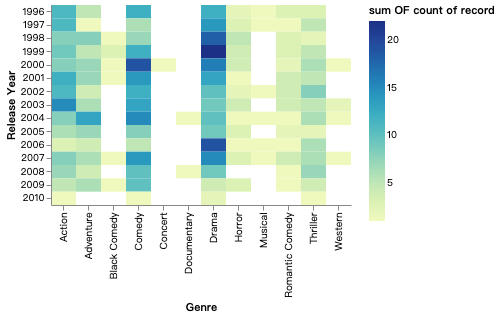

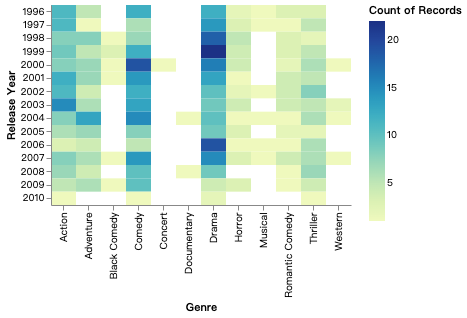

In [10]:
data_position = '../../assets/data/movies-w-year.csv'
vl_spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
 'data': {'format': {'type': 'csv'},
          'url': '../../assets/data/movies-w-year.csv'},
  "transform": [],
  'mark': {'tooltip': True, 'type': 'rect'},
  "width": 300,
  "height": 200,
  "encoding": {
    "x": {
      "field": "Genre"
    },
    "y": {
      "field": "Release Year"
    },
    "color": {
      "aggregate": "count",
      "type": "quantitative"
    }
  },
  "config": {
    "view": {
      "stroke": "transparent"
    }
  }
}
# vl_spec = {
#   "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
#  'data': {'format': {'type': 'csv'},
#           'url': '../../assets/data/movies-w-year.csv'},
#   "transform": [],
#   'mark': {'tooltip': True, 'type': 'rect'},
#   "width": 300,
#   "height": 200,
#   "encoding": {
#     "x": {
#       "bin": {"maxbins":60},
#       "field": "IMDB Rating",
#       "type": "quantitative"
#     },
#     "y": {
#       "bin": {"maxbins": 40},
#       "field": "Rotten Tomatoes Rating",
#       "type": "quantitative"
#     },
#     "color": {
#       "aggregate": "count",
#       "type": "quantitative"
#     }
#   },
#   "config": {
#     "view": {
#       "stroke": "transparent"
#     }
#   }
# }
show_transform_process(vl_spec, data_position, 'Title')

VegaLite(vl_spec)


------Overview of all the relevant fields-------


,Title,Genre,Release Year,Worldwide Gross,Content Rating
0,From Dusk Till Dawn,Horror,1996,25728961,R
1,Broken Arrow,Action,1996,148345997,R
2,City Hall,Drama,1996,20278055,R
3,Happy Gilmore,Comedy,1996,38623460,PG-13
4,Fargo,Thriller,1996,51204567,R
...,...,...,...,...,...
704,The City of Your Final Destination,Drama,2010,493296,PG-13
705,Robin Hood,Action,2010,310885538,PG-13
706,Inception,Thriller,2010,753830280,PG-13
707,Scott Pilgrim vs. The World,Comedy,2010,43149143,PG-13


------Final: After Aggregation-------
agg_chnals:
{'size': {'field': 'Release Year', 'op': 'mean', 'column_name_of_agg': 'mean OF Release Year'}, 'y': {'field': 'Worldwide Gross', 'op': 'sum', 'column_name_of_agg': 'sum OF Worldwide Gross'}}
groupby_chnals:
{'color': {'field': 'Genre'}, 'x': {'field': 'Content Rating'}}


,Genre,Content Rating,Title,Release Year,Worldwide Gross,mean OF Release Year,sum OF Worldwide Gross
0,Action,PG,The Phantom,1996,17220599,1996.000000,17220599
1,Action,PG-13,12 Rounds,2009,18184083,2002.847458,15422900884
2,Action,PG-13,2 Fast 2 Furious,2003,236220058,2002.847458,15422900884
3,Action,PG-13,2012,2009,766812167,2002.847458,15422900884
4,Action,PG-13,After the Sunset,2004,38329114,2002.847458,15422900884
...,...,...,...,...,...,...,...
704,Western,PG-13,Hidalgo,2004,107336658,2002.000000,178526493
705,Western,PG-13,Shanghai Noon,2000,71189835,2002.000000,178526493
706,Western,R,3:10 to Yuma,2007,69791889,2004.333333,176339041
707,Western,R,Open Range,2003,68293719,2004.333333,176339041


{'$schema': 'https://vega.github.io/schema/vega-lite/v4.json',
 'data': {'format': {'type': 'csv'}, 'url': 'tb4newVL.csv'},
 'encoding': {'color': {'field': 'Genre', 'type': 'nominal'},
              'size': {'field': 'mean OF Release Year', 'type': 'quantitative'},
              'x': {'field': 'Content Rating', 'type': 'nominal'},
              'y': {'field': 'sum OF Worldwide Gross', 'type': 'quantitative'}},
 'mark': {'tooltip': True, 'type': 'point'}}


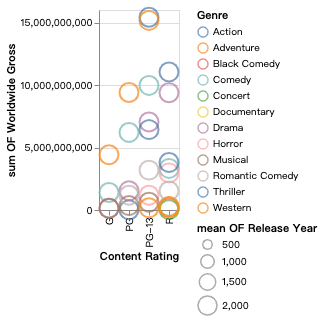

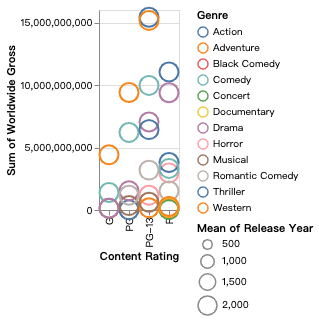

In [4]:
data_position = '../../assets/data/movies-w-year.csv'
vl_spec={'$schema': 'https://vega.github.io/schema/vega-lite/v4.json',
 'data': {'format': {'type': 'csv'},
          'url': '../../assets/data/movies-w-year.csv'},
 'encoding': {'size': {'aggregate': 'mean','field': 'Release Year', 'type': 'quantitative'},
              'color': {'field': 'Genre', 'type': 'nominal'},
              'x': {'field': 'Content Rating', 'type': 'nominal'},
              'y': {'aggregate': 'sum', 'field': 'Worldwide Gross', 'type': 'quantitative'}},
 'mark': {'tooltip': True, 'type': 'point'},
 'transform': []}
show_transform_process(vl_spec, data_position, 'Title')
VegaLite(vl_spec)


------Overview of all the relevant fields-------


,Genre,Creative Type,Title,Worldwide Gross
0,Horror,Fantasy,From Dusk Till Dawn,25728961
1,Action,Contemporary Fiction,Broken Arrow,148345997
2,Drama,Contemporary Fiction,City Hall,20278055
3,Comedy,Contemporary Fiction,Happy Gilmore,38623460
4,Thriller,Contemporary Fiction,Fargo,51204567
...,...,...,...,...
704,Drama,Contemporary Fiction,The City of Your Final Destination,493296
705,Action,Historical Fiction,Robin Hood,310885538
706,Thriller,Science Fiction,Inception,753830280
707,Comedy,Contemporary Fiction,Scott Pilgrim vs. The World,43149143


------After filter No.1-------
{'type': 'filter_str', 'field': 'Worldwide Gross', 'symbol': '>', 'value': 100000000.0}


,Genre,Creative Type,Title,Worldwide Gross
1,Action,Contemporary Fiction,Broken Arrow,148345997
6,Action,Contemporary Fiction,Twister,495900000
7,Adventure,Fantasy,Dragonheart,104364680
9,Action,Contemporary Fiction,The Rock,336069511
10,Comedy,Contemporary Fiction,The Cable Guy,102825796
...,...,...,...,...
695,Comedy,Contemporary Fiction,Couples Retreat,172450423
697,Thriller,Contemporary Fiction,Law Abiding Citizen,113190972
701,Action,Science Fiction,2012,766812167
705,Action,Historical Fiction,Robin Hood,310885538


------After filter No.2-------
{'type': 'filter_dict', 'field': 'Creative Type', 'range': ['Science Fiction', 'Fantasy']}


,Genre,Creative Type,Title,Worldwide Gross
15,Adventure,Science Fiction,Independence Day,817400878
43,Comedy,Science Fiction,Mars Attacks!,101371017
55,Action,Science Fiction,The Fifth Element,263900000
60,Adventure,Science Fiction,Men in Black,587790539
61,Drama,Science Fiction,Contact,165900000
...,...,...,...,...
640,Adventure,Fantasy,The Mummy: Tomb of the Dragon Emperor,397912118
662,Drama,Fantasy,Twilight,396439854
668,Drama,Fantasy,The Curious Case of Benjamin Button,329809326
674,Adventure,Fantasy,Monsters vs. Aliens,381687380


------Final: After Aggregation-------
agg_chnals:
{'y': {'field': 'Worldwide Gross', 'op': 'mean', 'column_name_of_agg': 'mean OF Worldwide Gross'}}
groupby_chnals:
{'x': {'field': 'Genre'}}


,Genre,Title,Worldwide Gross,mean OF Worldwide Gross
0,Action,2012,766812167,372087111.0
1,Action,End of Days,212026975,372087111.0
2,Action,Godzilla,376000000,372087111.0
3,Action,Minority Report,358824714,372087111.0
4,Action,Resident Evil: Extinction,146162920,372087111.0
...,...,...,...,...
61,Romantic Comedy,Enchanted,340384141,340384141.0
62,Thriller,District 9,206552113,383012970.5
63,Thriller,Inception,753830280,383012970.5
64,Thriller,Signs,408265690,383012970.5


{'$schema': 'https://vega.github.io/schema/vega-lite/v4.json',
 'data': {'format': {'type': 'csv'}, 'url': 'tb4newVL.csv'},
 'encoding': {'x': {'field': 'Genre', 'type': 'nominal'},
              'y': {'axis': {'format': 's'},
                    'field': 'mean OF Worldwide Gross',
                    'type': 'quantitative'}},
 'mark': {'tooltip': True, 'type': 'bar'}}


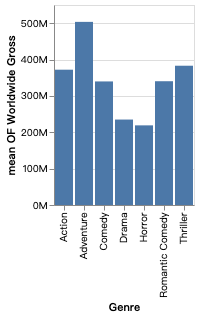

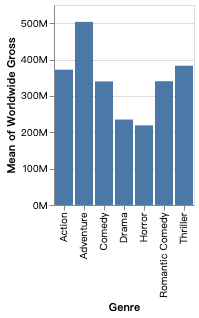

In [11]:
data_position = '../../assets/data/movies-w-year.csv'
vl_spec = {'$schema': 'https://vega.github.io/schema/vega-lite/v4.json',
 'data': {'format': {'type': 'csv'},
          'url': '../../assets/data/movies-w-year.csv'},
 'encoding': {'x': {'field': 'Genre', 'type': 'nominal'},
              'y': {'aggregate': 'mean',
                    'axis': {'format': 's'},
                    'field': 'Worldwide Gross',
                    'type': 'quantitative'}},
 'mark': {'tooltip': True, 'type': 'bar'},
 'transform': [{'filter': 'lower(datum["Worldwide Gross"]) > 100000000.0'},
               {'filter': {'field': 'Creative Type',
                           'oneOf': ['Science Fiction', 'Fantasy']}}]}
show_transform_process(vl_spec, data_position, 'Title')
VegaLite(vl_spec)


In [ ]:
data_position = '../../assets/data/movies-w-year.csv'
vl_spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
 'data': {'format': {'type': 'csv'},
          'url': '../../assets/data/movies-w-year.csv'},
  "transform": [{
    "filter": {"and": [
      {"field": "IMDB Rating", "valid": true},
      {"field": "Rotten Tomatoes Rating", "valid": true}
    ]}
  }],
  "mark": "rect",
  "width": 300,
  "height": 200,
  "encoding": {
    "x": {
      "bin": {"maxbins":60},
      "field": "IMDB Rating",
      "type": "quantitative"
    },
    "y": {
      "bin": {"maxbins": 40},
      "field": "Rotten Tomatoes Rating",
      "type": "quantitative"
    },
    "color": {
      "aggregate": "count",
      "type": "quantitative"
    }
  },
  "config": {
    "view": {
      "stroke": "transparent"
    }
  }
}


In [4]:
df = pd.read_excel("final_merged.xlsx")

In [5]:
df

,Genre,Title,Worldwide Gross,mean Worldwide Gross
0,Action,2012,766812167,372087111.0
1,NaN,End of Days,212026975,NaN
2,NaN,Godzilla,376000000,NaN
3,NaN,Minority Report,358824714,NaN
4,NaN,Resident Evil: Extinction,146162920,NaN
...,...,...,...,...
61,Romantic Comedy,Enchanted,340384141,340384141.0
62,Thriller,District 9,206552113,383012970.5
63,NaN,Inception,753830280,NaN
64,NaN,Signs,408265690,NaN


In [6]:
{'type': 'aggregation', 'op': 'sum', 'agg_field': 'Worldwide Gross', 'agg_dim': 'y', 'groupby':['Genre','Content Rating']}


{'type': 'aggregation',
 'op': 'sum',
 'agg_field': 'Worldwide Gross',
 'agg_dim': 'y',
 'groupby': ['Genre', 'Content Rating']}

In [8]:
df = pd.read_csv('../../assets/data/movies-w-year.csv') 
overview_df = df[['Worldwide Gross','Genre','Content Rating','IMDB Rating','Title',]]
overview_df

,Worldwide Gross,Genre,Content Rating,IMDB Rating,Title
0,25728961,Horror,R,7.1,From Dusk Till Dawn
1,148345997,Action,R,5.8,Broken Arrow
2,20278055,Drama,R,6.1,City Hall
3,38623460,Comedy,PG-13,6.9,Happy Gilmore
4,51204567,Thriller,R,8.3,Fargo
...,...,...,...,...,...
704,493296,Drama,PG-13,6.6,The City of Your Final Destination
705,310885538,Action,PG-13,6.9,Robin Hood
706,753830280,Thriller,PG-13,9.1,Inception
707,43149143,Comedy,PG-13,8.1,Scott Pilgrim vs. The World


In [12]:
overview_df.loc[0,['Worldwide Gross','Genre']].to_list()

[25728961, 'Horror']

In [11]:
# ref_dict=overview_df.groupby(['Genre','Content Rating']).sum(['Worldwide Gross'])#.to_dict()
# ref_dict

In [10]:
# group__dict = overview_df.groupby(['Genre','Content Rating','Title']).sum(['Worldwide Gross'])#.to_dict()
# group__dict

In [ ]:
df.groupby('A').agg({'B': ['min', 'max'], 'C': 'sum'})

In [10]:
ref_df = overview_df.groupby(['Genre','Content Rating']).agg({'Worldwide Gross':['sum'],'IMDB Rating':['mean']})
ref_dict = ref_df.to_dict()
ref_dict['sum OF Worldwide Gross'] = ref_dict.pop(('Worldwide Gross', 'sum'))
ref_dict['mean OF IMDB Rating'] = ref_dict.pop(('IMDB Rating', 'mean'))
ref_df=pd.DataFrame(ref_dict)
ref_df

sum OF Worldwide Gross  mean OF IMDB Rating
Action          PG                   17220599             4.800000
                PG-13             15422900884             6.233898
                R                 11046491267             6.539683
Adventure       G                  4413727463             6.921429
                PG                 9402901952             6.679310
...                                       ...                  ...
Romantic Comedy R                  1527690583             6.490000
Thriller        PG-13              6430530401             6.648148
                R                  3801296054             6.475000
Western         PG-13               178526493             6.600000
                R                   176339041             7.600000

[30 rows x 2 columns]

In [11]:
group_df = overview_df.groupby(['Genre','Content Rating','Title']).agg({'Worldwide Gross':['sum'],'IMDB Rating':['mean']})
group_dict = group_df.to_dict()
group_dict['Worldwide Gross'] = group_dict.pop(('Worldwide Gross', 'sum'))
group_dict['IMDB Rating'] = group_dict.pop(('IMDB Rating', 'mean'))
group_df=pd.DataFrame(group_dict)
group_df


Worldwide Gross  IMDB Rating
Action  PG    The Phantom              17220599          4.8
        PG-13 12 Rounds                18184083          5.4
              2 Fast 2 Furious        236220058          5.1
              2012                    766812167          6.2
              After the Sunset         38329114          6.2
...                                         ...          ...
Western PG-13 Hidalgo                 107336658          6.6
              Shanghai Noon            71189835          6.6
        R     3:10 to Yuma             69791889          7.9
              Open Range               68293719          7.5
              The Missing              38253433          7.4

[709 rows x 2 columns]

In [13]:
groupby_chnals={'color':{'field': 'Genre'}, 'x': {'field': 'Content Rating'}}
groupby_list = ['Genre','Content Rating']
agg_chnals={'y':{'field': 'Worldwide Gross','op':'sum','column_name_of_agg':'sum OF Worldwide Gross'},
           'z':{'field': 'IMDB Rating','op':'mean','column_name_of_agg':'mean OF IMDB Rating'}}
label_attr="Title"

In [15]:
new_group_dict=copy.deepcopy(group_dict)
for ch in agg_chnals:
    new_group_dict[agg_chnals[ch]['column_name_of_agg']] = {}
#     ft_op_comb = (agg_chnals[ch]['field'],agg_chnals[ch]['op'])
    for item in group_dict[ft_op_comb]:
        new_group_dict[agg_chnals[ch]['column_name_of_agg']][item]=ref_dict[agg_chnals[ch]['column_name_of_agg']][item[0:-1]]
output_df=pd.DataFrame(new_group_dict)
output_df
# output_df.index.names=[groupby_list.?????append(label_attr)]
# final=output_df.reset_index()
# final.to_csv('final.csv',index=False)

NameError: name 'ft_op_comb' is not defined

In [33]:
aa=(1,2,3)
aa[0:-1]

(1, 2)